Using population ±1.00%, lower bound = 1,306,587, population upper bound = 1,332,982, and number of districts = 3
Solver status: ok
Condition:     optimal
Objective:     9.085


District,Population,Deviation,Counties
0,"1,328,933",0.69%,"Cleveland, Lincoln, Logan, Oklahoma, Payne, Pottawatomie"
1,"1,322,138",0.18%,"Adair, Cherokee, Craig, Creek, Delaware, Kay, Mayes, Noble, Nowata, Okmulgee, Osage, Ottawa, Pawnee, Rogers, Tulsa, Wagoner, Washington"
2,"1,308,282",-0.87%,"Alfalfa, Atoka, Beaver, Beckham, Blaine, Bryan, Caddo, Canadian, Carter, Choctaw, Cimarron, Coal, Comanche, Cotton, Custer, Dewey, Ellis, Garfield, Garvin, Grady, Grant, Greer, Harmon, Harper, Haskell, Hughes, Jackson, Jefferson, Johnston, Kingfisher, Kiowa, Latimer, Le Flore, Love, Major, Marshall, McClain, McCurtain, McIntosh, Murray, Muskogee, Okfuskee, Pittsburg, Pontotoc, Pushmataha, Roger Mills, Seminole, Sequoyah, Stephens, Texas, Tillman, Washita, Woods, Woodward"
Total,"3,959,353",,


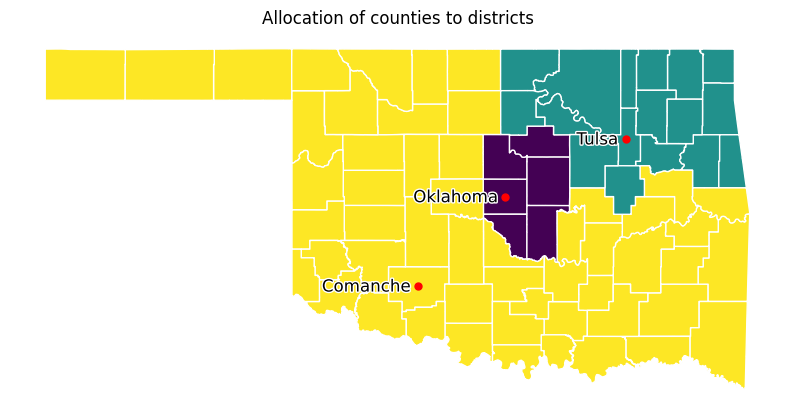

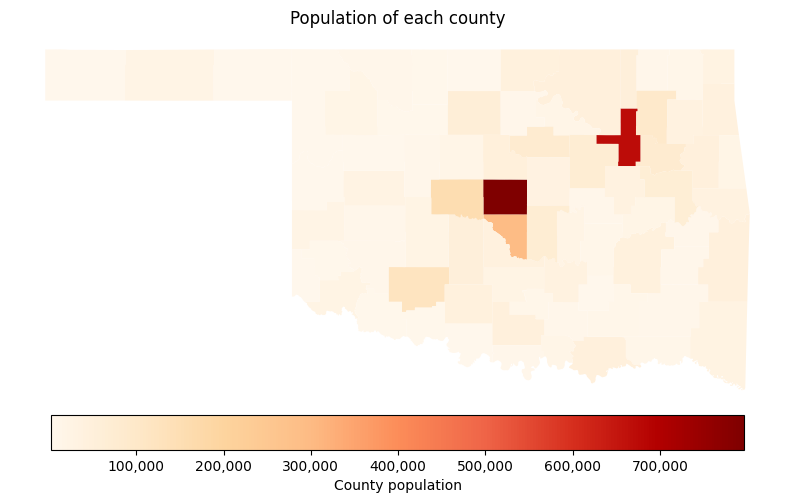

In [1]:
# Model 'D4-Min-Perimeter-with-Contiguity' converted to Pyomo and refactored
# Source: https://github.com/AustinLBuchanan/Districting-Examples-2020/tree/main

import json
import math
import networkx as nx
from networkx.readwrite import json_graph
import pyomo.environ as pyo
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.ticker as ticker

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data)

def initialize_graph(FILEPATH, FILENAME_JSON):
    graph = read_graph_from_json(FILEPATH + FILENAME_JSON)
    for node in graph.nodes:
        graph.nodes[node]['TOTPOP'] = graph.nodes[node]['P0010001']
    return graph

def calculate_population_bounds(graph, DEVIATION, NUM_DISTRICTS):
    total_population = sum(graph.nodes[node]['TOTPOP'] for node in graph.nodes)
    pop_lb = math.ceil((1 - DEVIATION / 2) * total_population / NUM_DISTRICTS)
    pop_ub = math.floor((1 + DEVIATION / 2) * total_population / NUM_DISTRICTS)
    return pop_lb, pop_ub

def create_model(graph, NUM_DISTRICTS, pop_lb, pop_ub):
    model = pyo.ConcreteModel()
    model.nodes = pyo.Set(initialize=list(graph.nodes()))
    model.edges = pyo.Set(initialize=list(graph.edges()))
    model.districts = pyo.RangeSet(0, NUM_DISTRICTS-1)
    model.assign = pyo.Var(model.nodes, model.districts, within=pyo.Binary)   # Equals one when county i is assigned to district j (originally x)
    model.cut = pyo.Var(model.edges, within=pyo.Binary)   # Equals one when edge {u,v} is cut (originally y)
    model.root = pyo.Var(model.nodes, model.districts, within=pyo.Binary)   # Equals 1 if node i is the "root" of district j (originally r)
    DG = nx.DiGraph(graph)
    model.directed_edges = pyo.Set(initialize=list(DG.edges()))
    model.flow = pyo.Var(model.directed_edges, within=pyo.NonNegativeReals)
    model.objective = pyo.Objective(rule=lambda model: sum(graph.edges[u, v]['shared_perim'] * model.cut[u, v] for u, v in model.edges), sense=pyo.minimize)
    model.one_district = pyo.Constraint(model.nodes, rule=lambda model, i: sum(model.assign[i, j] for j in model.districts) == 1)
    model.population_lower = pyo.Constraint(model.districts, rule=lambda model, j: sum(graph.nodes[i]['TOTPOP'] * model.assign[i, j] for i in model.nodes) >= pop_lb)
    model.population_upper = pyo.Constraint(model.districts, rule=lambda model, j: sum(graph.nodes[i]['TOTPOP'] * model.assign[i, j] for i in model.nodes) <= pop_ub)
    model.cut_edge = pyo.Constraint(model.edges, model.districts, rule=lambda model, u, v, j: model.assign[u, j] - model.assign[v, j] <= model.cut[u, v])
    model.one_root = pyo.Constraint(model.districts, rule=lambda model, j: sum(model.root[i, j] for i in model.nodes) == 1)
    model.root_assignment = pyo.Constraint(model.nodes, model.districts, rule=lambda model, i, j: model.root[i, j] <= model.assign[i, j])
    M = graph.number_of_nodes() - NUM_DISTRICTS + 1
    model.flow_conservation = pyo.Constraint(model.nodes, rule=lambda model, i: sum(model.flow[j, i] - model.flow[i, j] for j in graph.neighbors(i)) \
       >= 1 - M * sum(model.root[i, j] for j in model.districts))
    model.no_flow_cut_edge = pyo.Constraint(model.edges, rule=lambda model, i, j: model.flow[i, j] + model.flow[j, i] <= M * (1 - model.cut[i, j]))
    return model

def fix_district_roots(model, ROOTS):
    for district, root in ROOTS.items():
        model.root[ROOTS[district], district].fix(1)

def solve_model(model, TIME_LIMIT):
    solver = pyo.SolverFactory('appsi_highs')
    solver.options['time_limit'] = TIME_LIMIT
    solver.options['log_to_console'] = False
    solver.options['log_file'] = 'highs.log'   # Sometimes HiGHS doesn't update the console as it solves, so write log file too
    results = solver.solve(model, tee=False)
    return results

def print_results(results, model, graph, NUM_DISTRICTS):
    print(f'Solver status: {results.solver.status}')
    print(f'Condition:     {results.solver.termination_condition}')
    print(f'Objective:     {pyo.value(model.objective):,.3f}')
    districts = [[i for i in graph.nodes if pyo.value(model.assign[i, j]) > 0.5] for j in model.districts]
    district_counties = [[graph.nodes[i]['NAME20'] for i in districts[j]] for j in range(NUM_DISTRICTS)]
    district_populations = [sum(graph.nodes[i]['TOTPOP'] for i in districts[j]) for j in range(NUM_DISTRICTS)]
    total_population = sum(district_populations)
    ideal_population = total_population / NUM_DISTRICTS
    percentage_deviation = [(pop - ideal_population) / ideal_population for pop in district_populations]
    data = {
        'District': list(range(NUM_DISTRICTS)),
        'Population': district_populations,
        'Deviation': percentage_deviation,
        'Counties': [", ".join(sorted(counties)) for counties in district_counties]
    }
    df = pd.DataFrame(data)

    total_row = pd.DataFrame({
        'District': ['Total'],
        'Population': [total_population],
        'Deviation': [''],
        'Counties': ['']
    })
    df = pd.concat([df, total_row], ignore_index=True)
    
    df['Population'] = df['Population'].apply(lambda x: f"{x:,}")
    df['Deviation'] = df['Deviation'].apply(lambda x: f"{x:.2%}" if isinstance(x, float) else x)

    pd.set_option('display.max_colwidth', None)  # Ensure the Counties column wraps to display all values
    styled_df = df.style.set_properties(subset=['Counties'], **{'text-align': 'left'}).hide(axis='index')
    styled_df = styled_df.set_table_styles({'Counties': [{'selector': 'th', 'props': [('text-align', 'left')]}]})
    display(styled_df)
    
def draw_map(FILEPATH, FILENAME_SHP, graph, model, NUM_DISTRICTS, ROOTS):
    df = gpd.read_file(FILEPATH + FILENAME_SHP)
    df = df.to_crs(epsg=3857)  # Re-project Coordinate Reference System (CRS) so root markers work correctly
    assignment = [-1 for i in graph.nodes]
    labeling = {i: j for i in graph.nodes for j in range(NUM_DISTRICTS) if pyo.value(model.assign[i, j]) > 0.5}
    node_with_this_geoid = {graph.nodes[i]['GEOID20']: i for i in graph.nodes}
    for u in range(graph.number_of_nodes()):
        geoid = df['GEOID20'][u]
        i = node_with_this_geoid[geoid]
        assignment[u] = labeling[i]
    df['assignment'] = assignment
    
    # Allocation map
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_title('Allocation of counties to districts')
    df.plot(column='assignment', ax=ax, legend=False, edgecolor='white', linewidth=1.0)
    for district, root in ROOTS.items():   # Mark the district roots
        name = graph.nodes[root]['NAME20']
        x, y = df[df['GEOID20'] == graph.nodes[root]['GEOID20']].geometry.centroid.x.values[0], df[df['GEOID20'] == graph.nodes[root]['GEOID20']].geometry.centroid.y.values[0]
        ax.plot(x, y, marker='o', color='red', markersize=5)
        ax.text(x - 10000, y - 7500, name, fontsize=12, color='black', ha='right', path_effects=[pe.withStroke(linewidth=2, foreground="white")])
    ax.set_axis_off()
    plt.show()    

    # Population map
    df['TOTPOP'] = df['GEOID20'].map({graph.nodes[i]['GEOID20']: graph.nodes[i]['TOTPOP'] for i in graph.nodes})   # Add population data
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    df.plot(column='TOTPOP', ax=ax, legend=False, cmap='OrRd')
    sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=df['TOTPOP'].min(), vmax=df['TOTPOP'].max()))
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.045, pad=0.01)
    cbar.ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))   # Format the colorbar labels with commas
    cbar.set_label('County population')
    ax.set_title('Population of each county')
    ax.set_axis_off()
    plt.show()
    
def main():
    FILEPATH = 'districting-data\\'
    FILENAME_JSON = 'OK_county.json'
    FILENAME_SHP = 'OK_county.shp'
    DEVIATION = 0.02   # maximum population range relative to total population / number of districts
    NUM_DISTRICTS = 3
    ROOTS = {0: 6, 1: 34, 2: 8}  # Counties for district roots. e.g. 6 = Oklahoma, 8 = Comanche, 34 = Tulsa, 43 = Cimarron (from nodes in json file)
    ROOTS = {k: ROOTS[k] for k in list(ROOTS.keys())[:NUM_DISTRICTS]}   # Take up to the first NUM_DISTRICTS items from ROOTS
    TIME_LIMIT = 3600
    graph = initialize_graph(FILEPATH, FILENAME_JSON)
    pop_lb, pop_ub = calculate_population_bounds(graph, DEVIATION, NUM_DISTRICTS)
    print(f'Using population ±{DEVIATION/2:,.2%}, lower bound = {pop_lb:,.0f}, population upper bound = {pop_ub:,.0f}, and number of districts = {NUM_DISTRICTS:,.0f}')
    model = create_model(graph, NUM_DISTRICTS, pop_lb, pop_ub)
    fix_district_roots(model,ROOTS)
    results = solve_model(model, TIME_LIMIT)
    print_results(results, model, graph, NUM_DISTRICTS)
    draw_map(FILEPATH, FILENAME_SHP, graph, model, NUM_DISTRICTS, ROOTS)
    
if __name__ == "__main__":
    main()